# Feladatleírás

A mellékelt adathalmaz az Amazonon elérhető laptopok adatait tartalmazza.

Felelősségek lebontása:

<ul><li>Adatfeldolgozás
<li>Modellezés
<li>Prototipizálás / teszelés</ul>

Főbb megválaszolandó kérdések:
<ul>
<li>Mik az árak szélsőértékei, átlaga, mediánja, szórása?
<li>Hányféle CPU architektúra található meg az adathalmazban?
<li>Mik az árak szélsőértékei, átlaga, mediánja, szórása a különböző cpu architektúrákra nézve?
<li>Lineáris modell segítségével megjósolható-e egyedül a harddisk méret és a ram mérete alapján a készülék ára? Javítható-e a becslés ha figyelembe veszünk más paramétert is?
<li>Nagyjából azonos paramétereket (cpu, gpu, ram, stb.) feltételezve van-e összefüggés a gyártó és az ár között?</ul>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Adatok betöltése
file_path = 'laptop_prices.csv'  # Az adathalmaz elérési útvonala
data = pd.read_csv(file_path)

# Az adatok első néhány sorának megtekintése
print(data.head())

   brand                  model   screen_size       color harddisk  \
0   ROKC                    NaN     14 Inches        Blue  1000 GB   
1     HP                    NaN   15.6 Inches      Silver  1000 GB   
2    MSI  Vector GP66 12UGS-267  15.66 Inches  Core Black      NaN   
3  Apple            MacBook Air   13.3 Inches      Silver   256 GB   
4  Apple            MacBook Air   15.3 Inches    Midnight   256 GB   

             cpu    ram               OS  special_features    graphics  \
0  Intel Core i7   8 GB       Windows 11               NaN  Integrated   
1  Intel Core i5  64 GB   Windows 11 Pro  Backlit Keyboard  Integrated   
2  Intel Core i9  32 GB  Windows 11 Home               NaN   Dedicated   
3        Unknown   8 GB           Mac OS  Backlit Keyboard  Integrated   
4        Unknown   8 GB           Mac OS               NaN  Integrated   

  graphics_coprocessor cpu_speed  rating       price  
0                Intel   1.2 GHz     NaN    $589.99   
1                Intel  

## 1) Árak statiszikai jellemzői

Árak statisztikái:
    maximum = 11261.24, 
    minimum = 57.99, 
    átlag   = 1189.33, 
    medián  = 999.99,
    szórás  = 826.02


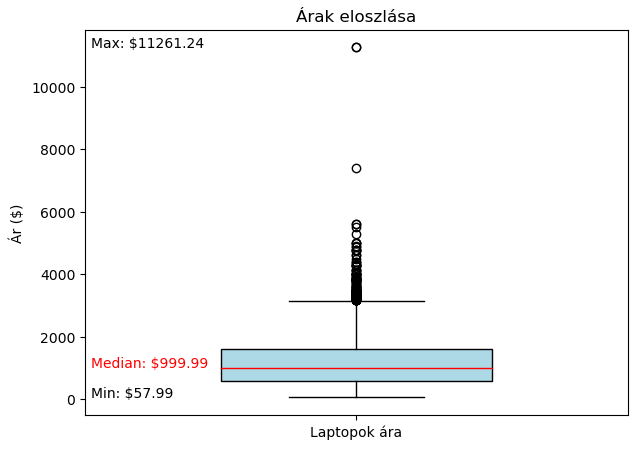

In [ ]:
# Tisztítjuk az ár oszlopot, eltávolítjuk a nem numerikus karaktereket, és átalakítjuk numerikus adattá
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# Alapvető statisztikai elemzések az árakra
price_stats = {
    "min": data['price'].min(),
    "max": data['price'].max(),
    "mean": data['price'].mean(),
    "median": data['price'].median(),
    "std": data['price'].std()
}

print(f"""Árak statisztikái:
    maximum = {price_stats['max']},
    minimum = {price_stats['min']},
    átlag   = {round(price_stats['mean'], 2)},
    medián  = {price_stats['median']},
    szórás  = {round(price_stats['std'], 2)}""")

# Boxplot készítése az árak eloszlásának vizsgálatához
plt.figure(figsize=(7, 5))
plt.boxplot(data['price'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'),
            widths=0.5)

# Feliratok hozzáadása a boxplothoz
plt.annotate(f"Min: ${price_stats['min']}", xy=(1, price_stats['min']), xytext=(0.51, price_stats['min']),
             fontsize=10, color='black')
plt.annotate(f"Max: ${price_stats['max']}", xy=(1, price_stats['max']), xytext=(0.51, price_stats['max']),
             fontsize=10, color='black')
plt.annotate(f"Median: ${price_stats['median']}", xy=(1, price_stats['median']), xytext=(0.51, price_stats['median']),
             fontsize=10, color='red')

plt.title('Árak eloszlása')
plt.ylabel('Ár ($)')
plt.xticks([1], ['Laptopok ára'])
plt.show()

## 2) Különböző CPU architektúrák száma

In [ ]:
# Egyedi CPU értékek megszámolása
cpu_architectures = data['cpu'].nunique()
print("Különböző CPU architektúrák száma:", cpu_architectures, "db")

Különböző CPU architektúrák száma: 141 db


## 3) Árak statisztikai jellemzői CPU architektúrák szerint

In [ ]:
# Táblázat készítése az árak statisztikai jellemzőiről CPU architektúrák szerint
cpu_price_stats = data.groupby('cpu')['price'].agg(['min', 'max', 'mean', 'median', 'std'])

print("Árak statisztikai jellemzői CPU architektúrák szerint csoportosítva:")
print(cpu_price_stats.head())

Árak statisztikai jellemzői CPU architektúrák szerint csoportosítva:
                                 min      max         mean    median  \
cpu                                                                    
1.2GHz Cortex A13 Processor   743.92   743.92   743.920000   743.920   
1.2GHz Cortex A8 Processor    129.99  1194.77   621.536667   609.495   
68000                        1149.00  1149.00  1149.000000  1149.000   
8032                          228.00  1999.00  1163.965789  1288.880   
A-Series                      253.46   399.99   326.725000   326.725   

                                    std  
cpu                                      
1.2GHz Cortex A13 Processor         NaN  
1.2GHz Cortex A8 Processor   370.930518  
68000                               NaN  
8032                         580.103479  
A-Series                     103.612357  


## 4) Lineáris modell az ár jóslására

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
data['harddisk'] = data['harddisk'].str.replace(r'[^\d\.]', '', regex=True)
data['ram'] = data['ram'].str.replace(r'[^\d\.]', '', regex=True)

# Konvertáljuk a 'harddisk' és 'ram' oszlopokat numerikus adattá
data['harddisk'] = pd.to_numeric(data['harddisk'], errors='coerce')
data['ram'] = pd.to_numeric(data['ram'], errors='coerce')

In [ ]:
# Kiválasztjuk a releváns oszlopokat, és eltávolítjuk a hiányzó értékeket
df_model = data[['price', 'harddisk', 'ram']].dropna()

# Meghatározzuk a független változókat (X) és a függő változót (y)
X = df_model[['harddisk', 'ram']]
y = df_model['price']

# Felosztjuk az adatokat tanító- és tesztkészletre
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Létrehozunk egy lineáris regressziós modellt
model = LinearRegression()

# Betanítjuk a modellt a tanítókészleten
model.fit(X_train, y_train)

# Előrejelzéseket készítünk a tesztkészleten
y_pred = model.predict(X_test)

# Kiértékeljük a modell teljesítményét
mse = mean_squared_error(y_test, y_pred)
print(f'Átlagos négyzetes hiba: {round(mse, 2)}')

# Megvizsgáljuk a modell együtthatóit
print(f'Metszéspont: {round(model.intercept_, 2)}')
print(f'''Együtthatók:
    harddisk: {round(model.coef_[0], 2)}
    ram: {round(model.coef_[1],2)}''')

Átlagos négyzetes hiba: 663822.76
Metszéspont: 683.73
Együtthatók: 
    harddisk: 0.04 
    ram: 18.77


### válasz:
A harddisk méret és a RAM mérete nem elegendő a laptop árának pontos előrejelzéséhez. Bár van némi kapcsolat, a magas MSE érték és az alacsony együtthatók arra utalnak, hogy más tényezők (pl. CPU, GPU, márka, kijelző méret stb.) is jelentős szerepet játszanak az ár meghatározásában. A modell pontossága javítható lenne, ha további releváns változókat is figyelembe vennénk.

## 5) Gyártó és ár közötti összefüggés

In [ ]:
import pandas as pd
import numpy as np

# Adat betöltése
df = pd.read_csv('laptop_prices.csv')